# SVM Model for UCI Adult ASD Detection

This notebook implements a Support Vector Machine (SVM) model for predicting Autism Spectrum Disorder (ASD) in adults using the UCI Adult Dataset in ARFF format.

## Features:
- **ARFF file loading**: Handles ARFF format files using scipy.io.arff
- **Data preprocessing**: Handles missing values, encodes categorical variables
- **Feature selection**: Uses A1-A10 scores and relevant demographic features
- **Hyperparameter tuning**: GridSearchCV for optimal parameters
- **Comprehensive evaluation**: Accuracy, precision, recall, specificity, AUC-ROC
- **Visualizations**: Confusion matrices, ROC curves, feature importance
- **Cross-validation**: 5-fold stratified cross-validation
- **Model saving**: Saves trained model, scaler, and encoders

## Target Features for Adults (18+):
- Age: 18 and more
- Gender: f, m
- Comprehensive ethnicity categories
- Extended country list
- Relation: Self, Parent, Health care professional, Relative, Others

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the UCI Adult Dataset (ARFF format)
data_path = r'e:\Users\Prajj\Documents\7th Sem\RM\Datasets\UCI Dataset\Autism-Adult-Data.arff'

# Load ARFF file
data, meta = arff.loadarff(data_path)

# Convert to DataFrame
df = pd.DataFrame(data)

# Decode byte strings to regular strings for object columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.decode('utf-8')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (704, 21)

First few rows:
  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0        1        1        1        1        0        0        1        1   
1        1        1        0        1        0        0        0        1   
2        1        1        0        1        1        0        1        1   
3        1        1        0        1        0        0        1        1   
4        1        0        0        0        0        0        0        1   

  A9_Score A10_Score  ...  gender       ethnicity jundice austim  \
0        0         0  ...       f  White-European      no     no   
1        0         1  ...       m          Latino      no    yes   
2        1         1  ...       m          Latino     yes    yes   
3        0         1  ...       f  White-European      no    yes   
4        0         0  ...       f               ?      no     no   

   contry_of_res used_app_before result     age_desc relation Class/ASD  
0  United St

In [3]:
# Data exploration
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nTarget variable distribution:")
print(df['Class/ASD'].value_counts())
print("\nAge description distribution:")
print(df['age_desc'].value_counts())
print("\nGender distribution:")
print(df['gender'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         704 non-null    object 
 1   A2_Score         704 non-null    object 
 2   A3_Score         704 non-null    object 
 3   A4_Score         704 non-null    object 
 4   A5_Score         704 non-null    object 
 5   A6_Score         704 non-null    object 
 6   A7_Score         704 non-null    object 
 7   A8_Score         704 non-null    object 
 8   A9_Score         704 non-null    object 
 9   A10_Score        704 non-null    object 
 10  age              702 non-null    float64
 11  gender           704 non-null    object 
 12  ethnicity        704 non-null    object 
 13  jundice          704 non-null    object 
 14  austim           704 non-null    object 
 15  contry_of_res    704 non-null    object 
 16  used_app_before  704 non-null    object 
 17  re

In [4]:
# Data preprocessing for Adult dataset
def preprocess_adult_data(df):
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Handle missing values represented as '?' in ARFF files
    df_processed = df_processed.replace('?', np.nan)
    
    # Handle missing values in age column
    age_imputer = SimpleImputer(strategy='median')
    df_processed['age'] = age_imputer.fit_transform(df_processed[['age']]).flatten()
    
    # Fill missing values in categorical columns
    categorical_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 
                       'used_app_before', 'age_desc', 'relation']
    
    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('Unknown')
    
    # Fill missing values in result column
    if 'result' in df_processed.columns:
        df_processed['result'] = df_processed['result'].fillna(df_processed['result'].median())
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
    
    # Encode target variable
    target_encoder = LabelEncoder()
    df_processed['Class/ASD'] = target_encoder.fit_transform(df_processed['Class/ASD'])
    
    return df_processed, label_encoders, target_encoder

# Preprocess the data
df_processed, label_encoders, target_encoder = preprocess_adult_data(df)
print("Data preprocessing completed!")
print("Processed dataset shape:", df_processed.shape)

Data preprocessing completed!
Processed dataset shape: (704, 21)


In [5]:
# Feature selection and target separation
# Select features (A1-A10 scores, age, and other relevant features)
feature_cols = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 
                'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
                'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res',
                'used_app_before', 'result', 'relation']

# Filter features that exist in the dataset
available_features = [col for col in feature_cols if col in df_processed.columns]
X = df_processed[available_features]
y = df_processed['Class/ASD']

print("Available features:", available_features)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Available features: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'relation']
Features shape: (704, 19)
Target shape: (704,)


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target distribution:")
print(pd.Series(y_train).value_counts())

Training set shape: (563, 19)
Test set shape: (141, 19)
Training target distribution:
Class/ASD
0    412
1    151
Name: count, dtype: int64


In [7]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print("Training features mean:", np.mean(X_train_scaled))
print("Training features std:", np.std(X_train_scaled))

Feature scaling completed!
Training features mean: -8.303060855381184e-19
Training features std: 1.0


In [8]:
# Define specificity score function
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

print("Starting hyperparameter tuning for Adult dataset...")
svm = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', 
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Starting hyperparameter tuning for Adult dataset...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 1.0


In [9]:
# Train the best SVM model
best_svm = grid_search.best_estimator_
print("Training the best SVM model for Adult dataset...")

# Train on full training set
best_svm.fit(X_train_scaled, y_train)
print("Model training completed!")

Training the best SVM model for Adult dataset...
Model training completed!


In [10]:
# Make predictions
y_train_pred = best_svm.predict(X_train_scaled)
y_test_pred = best_svm.predict(X_test_scaled)
y_test_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

print("Predictions completed!")

Predictions completed!


In [11]:
# Model evaluation
def evaluate_model(y_true, y_pred, y_proba=None, dataset_name=""):
    print(f"\n{dataset_name} Results:")
    print("="*50)
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        print(f"AUC-ROC: {auc:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['NO', 'YES']))
    
    return accuracy, precision, recall, specificity

# Evaluate on training and test sets
train_metrics = evaluate_model(y_train, y_train_pred, dataset_name="Adult Training Set")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, dataset_name="Adult Test Set")


Adult Training Set Results:
Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000

Classification Report:
              precision    recall  f1-score   support

          NO       1.00      1.00      1.00       412
         YES       1.00      1.00      1.00       151

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563


Adult Test Set Results:
Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

          NO       1.00      1.00      1.00       103
         YES       1.00      1.00      1.00        38

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



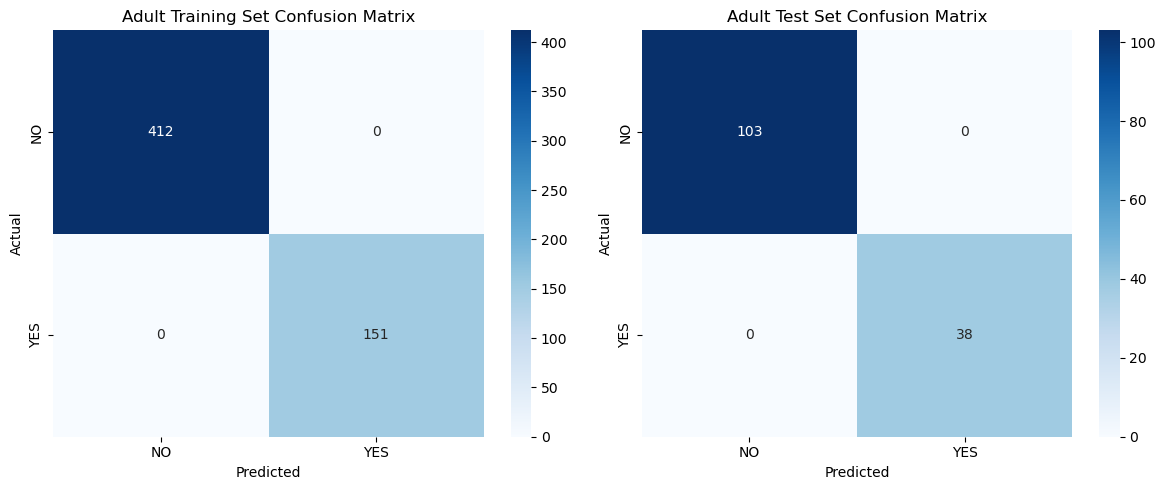

In [12]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'], ax=axes[0])
axes[0].set_title('Adult Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'], ax=axes[1])
axes[1].set_title('Adult Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

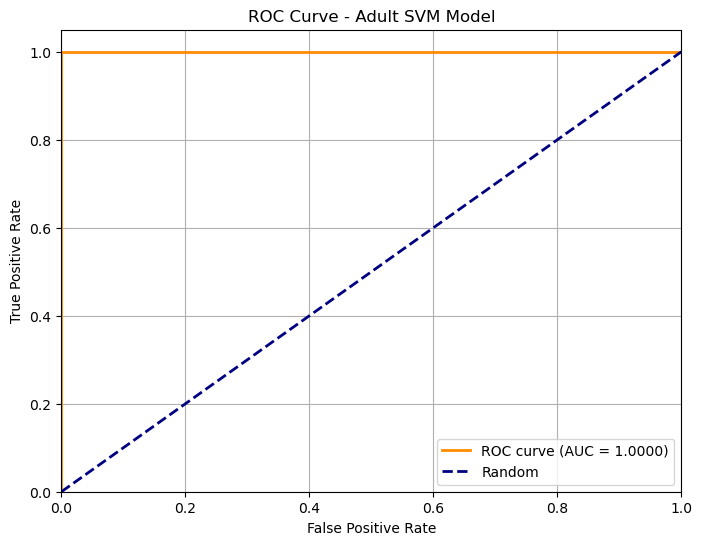

In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Adult SVM Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [14]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print("Cross-Validation Results:")
print("="*30)
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Results:
CV Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0000
Standard Deviation: 0.0000


Feature Importance (Linear SVM - Adult):
            feature    importance
17           result  1.347367e+00
3          A4_Score  7.369340e-01
4          A5_Score  7.367180e-01
1          A2_Score  7.358246e-01
2          A3_Score  7.333530e-01
9         A10_Score  7.296086e-01
6          A7_Score  7.277293e-01
7          A8_Score  7.099617e-01
8          A9_Score  6.903798e-01
5          A6_Score  6.659618e-01
0          A1_Score  6.622354e-01
10              age  9.238163e-05
13          jundice  6.255819e-05
18         relation  5.193183e-05
14           austim  3.237744e-05
12        ethnicity  9.555991e-06
15    contry_of_res  7.352666e-06
11           gender  1.412583e-06
16  used_app_before  3.538226e-17


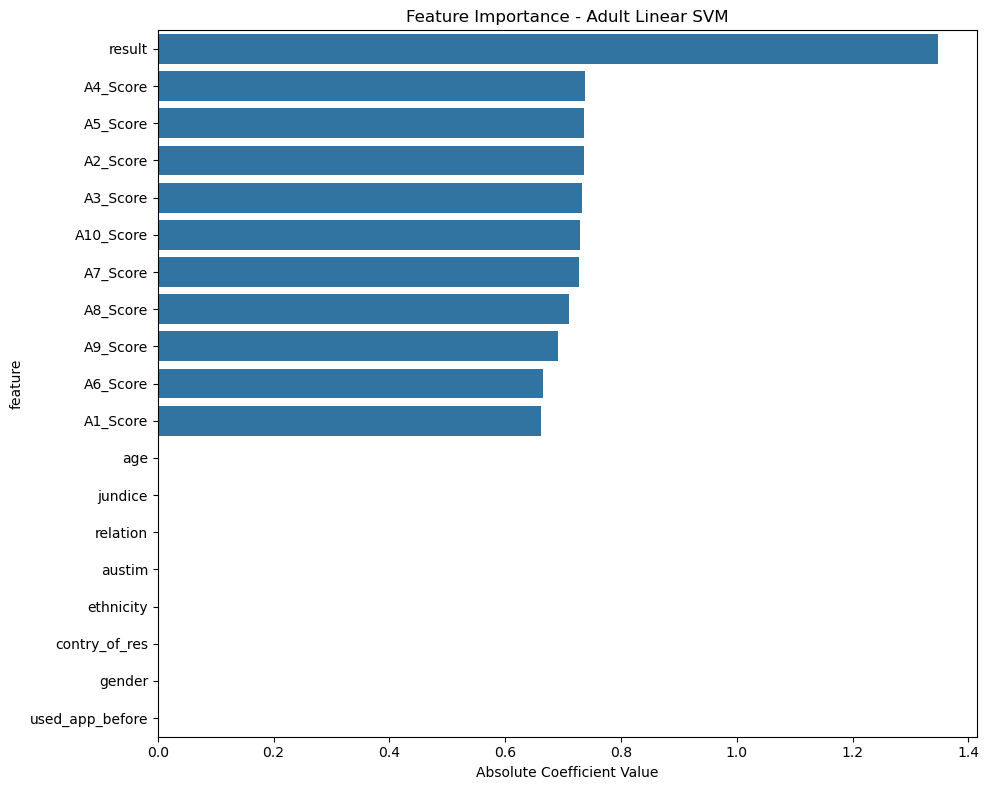

In [15]:
# Feature importance (for linear kernel)
if best_svm.kernel == 'linear':
    feature_importance = abs(best_svm.coef_[0])
    feature_names = available_features
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance (Linear SVM - Adult):")
    print(importance_df)
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Feature Importance - Adult Linear SVM')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance not available for {best_svm.kernel} kernel")

In [16]:
# Save the model and preprocessors
model_path = r'e:\Users\Prajj\Documents\7th Sem\RM\Codes\svm_adult_asd_model.pkl'
scaler_path = r'e:\Users\Prajj\Documents\7th Sem\RM\Codes\adult_scaler.pkl'
encoders_path = r'e:\Users\Prajj\Documents\7th Sem\RM\Codes\adult_label_encoders.pkl'

# Save the trained model
joblib.dump(best_svm, model_path)
print(f"Adult model saved to: {model_path}")

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Adult scaler saved to: {scaler_path}")

# Save the label encoders
joblib.dump({
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'feature_columns': available_features
}, encoders_path)
print(f"Adult encoders saved to: {encoders_path}")

Adult model saved to: e:\Users\Prajj\Documents\7th Sem\RM\Codes\svm_adult_asd_model.pkl
Adult scaler saved to: e:\Users\Prajj\Documents\7th Sem\RM\Codes\adult_scaler.pkl
Adult encoders saved to: e:\Users\Prajj\Documents\7th Sem\RM\Codes\adult_label_encoders.pkl


In [17]:
# Model summary
print("\n" + "="*60)
print("ADULT SVM MODEL SUMMARY")
print("="*60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cross-Validation Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Number of Features: {len(available_features)}")
print(f"Training Samples: {len(y_train)}")
print(f"Test Samples: {len(y_test)}")
print(f"Target: Adult ASD Detection (18+ years)")
print("="*60)


ADULT SVM MODEL SUMMARY
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Test AUC-ROC: 1.0000
Cross-Validation Score: 1.0000 ± 0.0000
Number of Features: 19
Training Samples: 563
Test Samples: 141
Target: Adult ASD Detection (18+ years)


In [18]:
# Function to make predictions on new adult data
def predict_adult_asd(model, scaler, encoders, new_data):
    """
    Function to predict ASD for new adult data
    
    Parameters:
    model: trained SVM model
    scaler: fitted StandardScaler
    encoders: dictionary containing label encoders
    new_data: dictionary or dataframe with new adult patient data
    
    Returns:
    prediction and probability
    """
    # Convert to dataframe if dictionary
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])
    
    # Apply same preprocessing
    processed_data = new_data.copy()
    
    # Handle missing values
    for col in processed_data.columns:
        if processed_data[col].isnull().any():
            if col == 'age':
                processed_data[col].fillna(processed_data[col].median(), inplace=True)
            else:
                processed_data[col].fillna('Unknown', inplace=True)
    
    # Apply label encoding
    for col, encoder in encoders['label_encoders'].items():
        if col in processed_data.columns:
            try:
                processed_data[col] = encoder.transform(processed_data[col].astype(str))
            except ValueError:
                # Handle unseen categories
                processed_data[col] = 0
    
    # Select features
    X_new = processed_data[encoders['feature_columns']]
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Make prediction
    prediction = model.predict(X_new_scaled)
    probability = model.predict_proba(X_new_scaled)
    
    # Decode prediction
    prediction_decoded = encoders['target_encoder'].inverse_transform(prediction)
    
    return prediction_decoded[0], probability[0]

print("Adult prediction function created!")
print("Use predict_adult_asd(best_svm, scaler, joblib.load(encoders_path), new_data) to make predictions")

Adult prediction function created!
Use predict_adult_asd(best_svm, scaler, joblib.load(encoders_path), new_data) to make predictions
